# ANAC


#### imports

In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

#### set seed

In [3]:
seed = 2024
np.random.seed(seed)

#### read in data

In [118]:
diet_csv = pd.read_csv("diet.csv").copy()
recipes_csv = pd.read_csv("recipes.csv").copy()
requests_csv = pd.read_csv("requests.csv").copy()
reviews_csv = pd.read_csv("reviews.csv").copy()

C:\Users\Maximilian Mittmann\AppData\Local\Temp\ipykernel_11120\3884275055.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_csv = pd.read_csv("reviews.csv").copy()


In [38]:
diet_csv.info() # 271907 entries
requests_csv.info() # 140195 entries
recipes_csv.info() #75604 entries
reviews_csv.info() # 140195 entries
# --> not all customers gave a review!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271907 entries, 0 to 271906
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   AuthorId  271907 non-null  object
 1   Diet      271906 non-null  object
 2   Age       271907 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140195 entries, 0 to 140194
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   AuthorId      140195 non-null  object 
 1   RecipeId      140195 non-null  int64  
 2   Time          140195 non-null  float64
 3   HighCalories  140195 non-null  float64
 4   HighProtein   140195 non-null  object 
 5   LowFat        140195 non-null  int64  
 6   LowSugar      140195 non-null  object 
 7   HighFiber     140195 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 8.6+ MB
<class 'pandas.core.frame.DataFra

### Data Cleaning
#### diet_csv

In [119]:
#rename column
diet_csv.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)
# Change type of Diet into category
diet_csv["Diet"] = diet_csv["Diet"].astype("category")


In [120]:
# delete row with missing value for diet
diet_csv = diet_csv.dropna(axis="rows")

In [6]:
diet_csv

,CustomerId,Diet,Age
0,10000120E,Vegetarian,46
1,1000014D,Vegan,18
2,1000015A,Vegetarian,58
3,1000016E,Vegetarian,32
4,1000027E,Vegan,61
...,...,...,...
271902,999917E,Vegetarian,28
271903,999936C,Omnivore,22
271904,99993D,Vegetarian,58
271905,99994A,Vegetarian,18


#### recipes_csv

In [121]:
# Change type for Recipe Category
recipes_csv["RecipeCategory"] = recipes_csv["RecipeCategory"].astype("category")


In [122]:
#drop recipeservings and yields and saturated + cholesterol + sodium + carbohydratecontent for now
recipes_csv = recipes_csv.drop("RecipeServings", axis=1)
recipes_csv = recipes_csv.drop("RecipeYield", axis=1)
recipes_csv = recipes_csv.drop("SaturatedFatContent", axis=1)
recipes_csv = recipes_csv.drop("CholesterolContent", axis=1)
recipes_csv = recipes_csv.drop("SodiumContent", axis=1)
recipes_csv = recipes_csv.drop("CarbohydrateContent", axis=1)
#also drop cook n preptime n quantities n parts
#recipes_csv = recipes_csv.drop("PrepTime", axis=1)
#recipes_csv = recipes_csv.drop("CookTime", axis=1)
recipes_csv = recipes_csv.drop("RecipeIngredientQuantities", axis=1)
recipes_csv = recipes_csv.drop("RecipeIngredientParts", axis=1)

In [123]:
df = recipes_csv
column_name = 'CookTime'
# Calculate IQR
Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)
IQR = Q3 - Q1
print("IQR:", IQR)

# Identify Outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_wo_outliers = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
df.loc[(df[column_name] < lower_bound) | (df[column_name] > upper_bound), column_name] = np.median(df_wo_outliers[column_name])

recipes_csv = df

IQR: 2100.0


In [124]:
df = recipes_csv
column_name = 'PrepTime'
# Calculate IQR
Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)
IQR = Q3 - Q1
print("IQR:", IQR)

# Identify Outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_wo_outliers = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
df.loc[(df[column_name] < lower_bound) | (df[column_name] > upper_bound), column_name] = np.median(df_wo_outliers[column_name])

recipes_csv = df

IQR: 600.0


In [29]:
recipes_csv

,RecipeId,Name,CookTime,PrepTime,RecipeCategory,Calories,FatContent,FiberContent,SugarContent,ProteinContent
0,73440,Bow Ties With Broccoli Pesto,0,1800,Other,241.3,10.1,2.3,1.4,6.7
1,365718,Cashew-chutney Rice,3600,600,Other,370.8,17.5,1.6,2.2,9.4
2,141757,Copycat Taco Bell Nacho Fries BellGrande,3600,2700,Other,377.6,20.9,3.8,6.1,12.9
3,280351,Slow Cooker Jalapeno Cheddar Cheese Soup,18000,1800,Other,282.8,16.5,2.3,2.7,11.7
4,180505,Cool & Crisp Citrus Chiffon Pie,3600,1800,Other,257.5,8.6,0.4,30.2,6.3
...,...,...,...,...,...,...,...,...,...,...
75599,253577,Frijoles Negros- Crock Pot Mexican Black Beans,43200,3028,Other,121.5,0.5,7.8,0.6,7.9
75600,267827,Moose Moussaka,3600,2700,Other,652.2,25.8,7.5,7.2,50.1
75601,266983,Cantonese Pepper Steak for Two (Or More),1800,900,Other,223.9,9.2,1.1,1.7,26.7
75602,253739,Coconut Cream Cooler,300,120,Other,2229.8,80.3,15.7,317.9,26.7


In [125]:
from scipy.stats import skew, kurtosis

df = recipes_csv
column_name = 'Calories'
# Calculate IQR
Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)
IQR = Q3 - Q1
print("IQR:", IQR)

# Identify Outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
df_wo_outliers = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
df.loc[(df[column_name] < lower_bound) | (df[column_name] > upper_bound), column_name] = np.median(
    df_wo_outliers[column_name])

continuous_data = df[column_name]
recipes_csv = df

# Central Tendency
mean_value = np.mean(continuous_data)
median_value = np.median(continuous_data)
mode_value = continuous_data.mode().values[0]

# Dispersion
range_value = continuous_data.max() - continuous_data.min()
quartiles = np.percentile(continuous_data, [25, 75])
iqr = quartiles[1] - quartiles[0]
variance_value = np.var(continuous_data)
std_deviation_value = np.std(continuous_data)
skewness_value = skew(continuous_data)
kurtosis_value = kurtosis(continuous_data)

# Print results
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Mode: {mode_value}")
print(f"Range: {range_value}")
print(f"IQR: {iqr}")
print(f"Min: {continuous_data.min()}")
print(f"Max: {continuous_data.max()}")
print(f"Variance: {variance_value}")
print(f"Standard Deviation: {std_deviation_value}")
print(f"Skewness: {skewness_value}")
print(f"Kurtosis: {kurtosis_value}")


IQR: 355.7
Mean: 339.120381196762
Median: 296.9
Mode: 296.9
Range: 1063.8
IQR: 281.40000000000003
Min: 0.0
Max: 1063.8
Variance: 48656.07552516552
Standard Deviation: 220.5812220592803
Skewness: 0.9254862393321386
Kurtosis: 0.49127181138460996


In [126]:
df = recipes_csv
column_name = 'FatContent'
# Calculate IQR
Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)
IQR = Q3 - Q1
print("IQR:", IQR)
print(Q1)
print(Q3)

# Identify Outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 2.0 * IQR
df_wo_outliers = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
df.loc[(df[column_name] < lower_bound) | (df[column_name] > upper_bound), column_name] = np.median(
    df_wo_outliers[column_name])

print(lower_bound)
print(upper_bound)

recipes_csv = df

IQR: 21.9
5.6
27.5
-27.249999999999993
71.3


In [127]:
df = recipes_csv
column_name = 'FiberContent'
# Calculate IQR
Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)
IQR = Q3 - Q1
print("IQR:", IQR)

# Identify Outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_wo_outliers = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
df.loc[(df[column_name] < lower_bound) | (df[column_name] > upper_bound), column_name] = np.median(
    df_wo_outliers[column_name])

recipes_csv = df

IQR: 3.7


In [128]:
df = recipes_csv
column_name = 'SugarContent'
# Calculate IQR
Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)
IQR = Q3 - Q1
print("IQR:", IQR)

# Identify Outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_wo_outliers = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
df.loc[(df[column_name] < lower_bound) | (df[column_name] > upper_bound), column_name] = np.median(
    df_wo_outliers[column_name])

recipes_csv = df

IQR: 15.600000000000001


In [129]:
df = recipes_csv
column_name = 'ProteinContent'
# Calculate IQR
Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)
IQR = Q3 - Q1
print("IQR:", IQR)

# Identify Outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_wo_outliers = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
df.loc[(df[column_name] < lower_bound) | (df[column_name] > upper_bound), column_name] = np.median(
    df_wo_outliers[column_name])

recipes_csv = df

IQR: 21.6


##### requests_csv

In [111]:
requests_csv

,AuthorId,RecipeId,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber
0,2001012259B,73440,1799.950949,0.0,Indifferent,0,0,0
1,437641B,365718,4201.820980,0.0,Yes,0,Indifferent,1
2,1803340263D,141757,6299.861496,0.0,Indifferent,1,Indifferent,0
3,854048B,280351,19801.365796,0.0,Yes,1,0,1
4,2277685E,180505,5400.093457,0.0,Indifferent,0,0,0
...,...,...,...,...,...,...,...,...
140190,163793B,78171,1560.649725,0.0,Indifferent,0,0,1
140191,33888B,333262,1502.011466,1.0,Indifferent,1,0,0
140192,401942C,49200,5999.274269,0.0,Indifferent,0,0,1
140193,346866B,214815,899.523513,0.0,Yes,1,Indifferent,1


In [130]:
#rename column
requests_csv.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)
# Map indifferent values for HighProtein and LowSugar
requests_csv["HighProtein"] = requests_csv["HighProtein"].map({
    "Indifferent": 0,
    "0": 0,
    "1": 1,
    "Yes": 1
})

requests_csv["LowSugar"] = requests_csv["LowSugar"].map({
    "Indifferent": 0,
    "0": 0,
    "1": 1
})


In [131]:
# Change types to boolean
requests_csv["HighCalories"] = requests_csv["HighCalories"].astype("bool")
requests_csv["LowFat"] = requests_csv["LowFat"].astype("bool")
requests_csv["HighFiber"] = requests_csv["HighFiber"].astype("bool")
requests_csv["HighProtein"] = requests_csv["HighProtein"].astype("bool")
requests_csv["LowSugar"] = requests_csv["LowSugar"].astype("bool")
requests_csv = requests_csv.drop(columns=["LowSugar"])

In [132]:
# Replace negative time requests with 0 and round time values to int
requests_csv['Time'] = np.where(requests_csv['Time'] < 0, 0, requests_csv['Time'])
requests_csv['Time'] = requests_csv['Time'].round().astype('int')
requests_csv.rename(columns={'Time':'RequestedTime'}, inplace=True)

In [133]:
# replace outliers in requested time
from scipy.stats import skew, kurtosis

df = requests_csv
column_name = 'RequestedTime'
# Calculate IQR
Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)
IQR = Q3 - Q1
print("IQR:", IQR)

# Identify Outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
df_wo_outliers = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
df.loc[(df[column_name] < lower_bound) | (df[column_name] > upper_bound), column_name] = np.median(
    df_wo_outliers[column_name])

continuous_data = df[column_name]
requests_csv = df

# Central Tendency
mean_value = np.mean(continuous_data)
median_value = np.median(continuous_data)
mode_value = continuous_data.mode().values[0]

# Dispersion
range_value = continuous_data.max() - continuous_data.min()
quartiles = np.percentile(continuous_data, [25, 75])
iqr = quartiles[1] - quartiles[0]
variance_value = np.var(continuous_data)
std_deviation_value = np.std(continuous_data)
skewness_value = skew(continuous_data)
kurtosis_value = kurtosis(continuous_data)

# Print results
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Mode: {mode_value}")
print(f"Range: {range_value}")
print(f"IQR: {iqr}")
print(f"Min: {continuous_data.min()}")
print(f"Max: {continuous_data.max()}")
print(f"Variance: {variance_value}")
print(f"Standard Deviation: {std_deviation_value}")
print(f"Skewness: {skewness_value}")
print(f"Kurtosis: {kurtosis_value}")


IQR: 2999.0
Mean: 2485.566910374835
Median: 2100.0
Mode: 2100
Range: 8698
IQR: 2099.0
Min: 0
Max: 8698
Variance: 2832004.94001282
Standard Deviation: 1682.8561851842303
Skewness: 1.2251658523258762
Kurtosis: 1.5999863728088197


In [116]:
requests_csv

,CustomerId,RecipeId,RequestedTime,HighCalories,HighProtein,LowFat,HighFiber
0,2001012259B,73440,1800,False,False,False,False
1,437641B,365718,4202,False,True,False,True
2,1803340263D,141757,6300,False,False,True,False
3,854048B,280351,2100,False,True,True,True
4,2277685E,180505,5400,False,False,False,False
...,...,...,...,...,...,...,...
140190,163793B,78171,1561,False,False,False,True
140191,33888B,333262,1502,True,False,True,False
140192,401942C,49200,5999,False,False,False,True
140193,346866B,214815,900,False,True,True,True


#### reviews_csv

In [134]:
# Rename column
reviews_csv.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)
# Remove NA rows and Rating column and TestSetId
reviews_csv = reviews_csv.drop("Rating", axis=1)
reviews_csv.dropna(subset=["Like"], inplace=True) # note: now the entries are reduced to 97381 entries
reviews_csv = reviews_csv.drop("TestSetId", axis=1)

In [135]:
# convert Like type to boolean
reviews_csv["Like"] = reviews_csv["Like"].astype("boolean")

In [276]:
reviews_csv

,CustomerId,RecipeId,Like
42814,1000036C,320576,False
42815,1000216B,189335,False
42816,1000221A,133043,False
42817,1000221A,90537,False
42818,1000221A,334314,False
...,...,...,...
140190,999595E,338070,False
140191,999774A,29002,False
140192,999774A,159252,False
140193,999774A,1171,True


#### Join the tables

In [277]:
requests_csv

,CustomerId,RecipeId,RequestedTime,HighCalories,HighProtein,LowFat,HighFiber
0,2001012259B,73440,1800,False,False,False,False
1,437641B,365718,4202,False,True,False,True
2,1803340263D,141757,6300,False,False,True,False
3,854048B,280351,19801,False,True,True,True
4,2277685E,180505,5400,False,False,False,False
...,...,...,...,...,...,...,...
140190,163793B,78171,1561,False,False,False,True
140191,33888B,333262,1502,True,False,True,False
140192,401942C,49200,5999,False,False,False,True
140193,346866B,214815,900,False,True,True,True


In [136]:
# merge diet + request
request_with_diet = pd.merge(diet_csv, requests_csv, how="inner", on="CustomerId")

In [137]:
# merge diet + request + recipe
request_with_diet_and_recipe = pd.merge(recipes_csv, request_with_diet, how="inner", on="RecipeId")

In [138]:
# merge diet + request + recipe + review
request_with_diet_recipe_and_review = pd.merge(reviews_csv, request_with_diet_and_recipe, how="inner", on=["CustomerId", "RecipeId"])

In [139]:
# One hot encoding for categorical variables
df = pd.get_dummies(request_with_diet_recipe_and_review, columns=["Diet", "RecipeCategory"], drop_first=True)

In [140]:
# Split dataset into train and test df
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.20, stratify=request_with_diet_recipe_and_review['Like'], random_state=seed)

***Train Model***


In [163]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score
                                              
train_model = RandomForestClassifier(n_estimators=100, max_features=1.0, random_state=seed)

X = train_df.drop(columns=["Like", "CustomerId", "RecipeId", "Name"])
y = train_df["Like"]

train_model.fit(X,y)

# Calculate balanced accuracy
pred = train_model.predict(X)
score = np.mean(cross_val_score(train_model, X, y, cv=4, scoring="balanced_accuracy"))
print("Cross validation score for balanced accuracy: " + str(score))

# Report scores on model
y_pred = train_model.predict(X)
print("Precision:", precision_score(y, y_pred))
print("Accuracy:", accuracy_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))
print("Balanced Accuracy", balanced_accuracy_score(y, y_pred))


Cross validation score for balanced accuracy: 0.684135697261182
Precision: 0.9998056365403304
Accuracy: 0.9997946190182789
Recall: 0.9986410405746458
Balanced Accuracy 0.9993057278255614


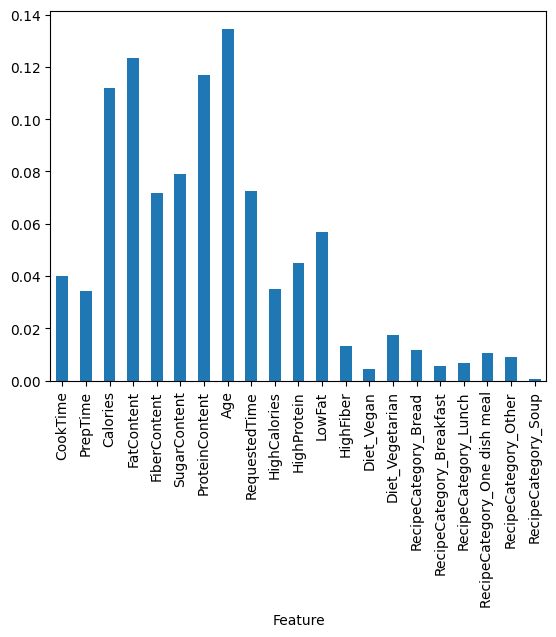

In [164]:
# Plot feature importance 

importance_values = train_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_values})
imp_plot = importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
imp_plot.plot()
plt.show()

***Test Model***

In [141]:
test_df = test_df.drop(columns=["CustomerId", "RecipeId", "Name"])

In [165]:
test_predictions = train_model.predict(test_df.drop(columns="Like"))
test_probabilities = train_model.predict_proba(test_df.drop(columns="Like"))

test_predictions_df = pd.DataFrame({'Like': test_df['Like'], 
                                     'Predicted_Like': test_predictions,
                                     'Probability_Like=0': test_probabilities[:, 0],
                                     'Probability_Like=1': test_probabilities[:, 1]})
print(test_predictions_df)


# Confusion Matrix
conf_matrix = confusion_matrix(test_df['Like'], test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Precision, accuracy, recall
print("Test-Precision:", precision_score(test_df['Like'], test_predictions))
print("Test-Accuracy:", accuracy_score(test_df['Like'], test_predictions))
print("Test-Recall:", recall_score(test_df['Like'], test_predictions))
print("Test Balanced Accuracy:", balanced_accuracy_score(test_df["Like"], test_predictions))

        Like  Predicted_Like  Probability_Like=0  Probability_Like=1
25046  False             0.0                0.76                0.24
40124   True             0.0                0.78                0.22
49430  False             0.0                1.00                0.00
71939  False             0.0                1.00                0.00
630    False             0.0                0.99                0.01
...      ...             ...                 ...                 ...
91766  False             0.0                0.89                0.11
27153  False             0.0                0.99                0.01
51545  False             0.0                1.00                0.00
25071  False             0.0                0.93                0.07
59952  False             0.0                1.00                0.00

[19477 rows x 4 columns]
Confusion Matrix:
[[16287   614]
 [ 1505  1071]]
Test-Precision: 0.6356083086053412
Test-Accuracy: 0.891205011038661
Test-Recall: 0.41576086956521

In [154]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

train_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.2, random_state=seed)

X = train_df.drop(columns=["Like", "CustomerId", "RecipeId", "Name"])
y = train_df["Like"]

train_model.fit(X,y)

score = np.mean(cross_val_score(train_model, X, y, cv=4, scoring="balanced_accuracy"))
print("Cross validation score for balanced accuracy: " + str(score))

Cross validation score for balanced accuracy: 0.6768081434104495


In [153]:
# Test Model
test_predictions = train_model.predict(test_df)
test_probabilities = train_model.predict_proba(test_df)

X_test = test_df.drop(columns=["Like"])
y_test = test_df["Like"]

train_model.score(X_test, y_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Like



#### 1. Logistic Regression
#### 2. Decision Trees
#### 3. Random Forest
#### 4. Naive bayes
#### 5. Gradient Boosting

#### 1. Data Cleaning (missing values, merge tables)
#### 2. Set dataset into training & testing sets + download testing set
#### 3. modeling
#### 4. Model training: train model on training dataset
#### 5. Model evaluation (performance)
#### 6. prediction on the unseen data